In [1]:
import numpy as np # linear algebra
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import datetime as dt

%matplotlib inline

In [2]:
class Baobab(object):
    def __init__(self, path, fnames=['nmult', 'cmult', 'axis1', 'axis2', 'ptD']):
        self.fnames = fnames
        raw = np.loadtxt(path, delimiter=',', dtype=np.float32)
        np.random.shuffle(raw)
        total_size = len(raw)
        train, valid, test = np.split(raw, [int(.6*total_size), int(.8*total_size)])
        self.darr = {
            'train':{'X':train[:,1:], 'Y':train[:,0]},
            'valid':{'X':valid[:,1:], 'Y':valid[:,0]},
            'test':{'X':test[:,1:], 'Y':test[:,0]}
        }
        self.dmat = {
            'train':xgb.DMatrix(data=train[:,1:], label=train[:,0], feature_names=fnames),
            'valid':xgb.DMatrix(data=valid[:,1:], label=valid[:,0], feature_names=fnames),
            'test':xgb.DMatrix(data=test[:,1:], label=test[:,0], feature_names=fnames)
        }
        self.watchlist = [(self.dmat['train'], 'train'),
                          (self.dmat['valid'], 'valid')]
        
    def set_params(self, eta=0.1, gamma=0, max_depth=6, subsample=1, colsample_bytree=1,
                   min_chil_weight=1, random_state=0, eval_metric='error'):
        self.params = {
            "objective": "binary:logistic",
            "booster" : "gbtree",
            "eval_metric":eval_metric,
            "eta": eta,
            "gamma": gamma,
            "tree_method": 'exact',
            "max_depth": max_depth,
            "subsample": subsample,
            "colsample_bytree": colsample_bytree,
            "silent": 1,
            "min_chil_weight":min_chil_weight,
            "seed": random_state
        }
        
    def train(self, num_boost_round=10, early_stopping_rounds=None):
        # xgb.train(params, dtrain, num_boost_round, evals=())
        self.gbm = xgb.train(self.params, self.dmat['train'],
                             num_boost_round=num_boost_round,
                             evals=self.watchlist,
                             early_stopping_rounds=early_stopping_rounds)
    def eval_roc(self):
        self.check = self.gbm.predict(xgb.DMatrix(self.darr['valid']['X'], feature_names=self.fnames),
                                 ntree_limit=self.gbm.best_iteration+1)
        self.fpr, self.tpr, _ = roc_curve(self.darr['valid']['Y'],
                                          self.check)
        self.fnr = 1 - self.fpr
        self.auc = auc(self.fpr, self.tpr)

    def save_roc(self, save_path):
        self.logs = np.vstack([self.tpr, self.fnr, self.fpr]).T
        lname = os.path.join(save_path, 'roc_log.csv')
        np.savetxt(lname, self.logs, delimiter=',', header='tpr, fnr, fpr')
        
    def plot_roc_curve(self, plot_path):
        fig, ax = plt.subplots()
        plt.plot(self.tpr, self.fnr, color='darkorange', lw=2,
                 label='ROC curve (auc = %0.2f)' % self.auc)
        plt.plot([0,1], [1,1], color='navy', lw=2, linestyle='--')
        plt.plot([1,1], [0,1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.1])
        plt.ylim([0.0, 1.1])
        plt.xlabel('Quark Jet Efficiency (TPR)')
        plt.ylabel('Gluon Jet Rejection (FNR)')
        plt.title('XGBoost')
        plt.legend(loc="lower left")
        ax.grid()
        plt.savefig(plot_path)
        plt.show()
        
    def plot_tree(self): 
        fig, ax = plt.subplots(1,1,figsize=(300, 600))
        xgb.plot_tree(booster=self.gbm, ax=ax, num_trees=1)
        plt.show()

In [3]:
bb = Baobab('./data/jet4np.csv')

In [4]:
bb.set_params(gamma=0.1, max_depth=2, eval_metric='auc')

In [5]:
bb.train(num_boost_round=30)

[0]	train-auc:0.752983	valid-auc:0.752129
[1]	train-auc:0.766492	valid-auc:0.765737
[2]	train-auc:0.775404	valid-auc:0.774164
[3]	train-auc:0.776328	valid-auc:0.775148
[4]	train-auc:0.776909	valid-auc:0.775712
[5]	train-auc:0.778465	valid-auc:0.777124
[6]	train-auc:0.779814	valid-auc:0.778717
[7]	train-auc:0.780095	valid-auc:0.779035
[8]	train-auc:0.780897	valid-auc:0.779741
[9]	train-auc:0.782367	valid-auc:0.781117
[10]	train-auc:0.782623	valid-auc:0.781331
[11]	train-auc:0.783742	valid-auc:0.782447
[12]	train-auc:0.784608	valid-auc:0.783228
[13]	train-auc:0.784864	valid-auc:0.783499
[14]	train-auc:0.785482	valid-auc:0.784061
[15]	train-auc:0.786101	valid-auc:0.784678
[16]	train-auc:0.786354	valid-auc:0.784955
[17]	train-auc:0.786756	valid-auc:0.785335
[18]	train-auc:0.787215	valid-auc:0.785753
[19]	train-auc:0.787684	valid-auc:0.786179
[20]	train-auc:0.788109	valid-auc:0.786461
[21]	train-auc:0.788731	valid-auc:0.787045
[22]	train-auc:0.788894	valid-auc:0.787139
[23]	train-auc:0.7890

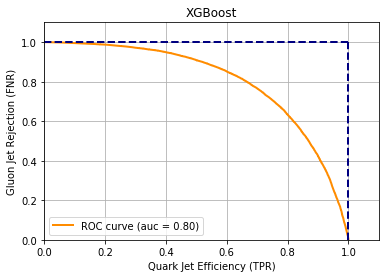

In [61]:
bb.plot_roc_curve('./hi.png')

In [6]:
bb.plot_tree()